# SLAM based on USIP keypoints

Association between keypoints:
* Only between consequtive frames (no loop-closures)
* Based on distance thresholding
* Initial guess for matching is done by A-LOAM odometry prior estimation 

### Data
####  Keypoints
Extracted keypoints from KITTI dataset using USIP: [Google Drive](https://drive.google.com/file/d/1Oa5X4mjT7l_7z8VdunC43UMf8L-gG8pu/view?usp=sharing).

Keypoints per pcd: 64

Non-maximum supprestion distance: 2 meters

#### KITTI

Download odometry GT from [original dataset page](http://www.cvlibs.net/datasets/kitti/eval_odometry.php).

### Imports and main parameters

In [1]:
import open3d as o3d
import numpy as np
import os
import mrob
from scipy import spatial
import collections
import time
from IPython.display import clear_output

In [2]:
# Relative distance thresholding for landmarks association
DIST_THRESHOLD = 0.05

# Number of map in KITTI dataset
MAP = '00'

# Specify here path to downloaded keypoints
KEYPOINTS_PATH = '../../keypoints_kitti_64_2/' + MAP + '/'

# Specify here path to odometry GT for KITTI dataset
KITTI_GT_PATH = '../../data_odometry_poses_USIP/dataset/poses/' + MAP + '.txt'

# Path to original point clouds from KITTI dataset
KITTI_PCDS_PATH = '/home/anastasiya/data/data_odometry_velodyne/dataset/sequences/00/velodyne/'

## Utils

In [3]:
# Returns numpy presentation of point cloud
def get_point_cloud(path, is_keypoint=False):
    pcd_np = None
    if path.endswith('npy'):
        pcd_np = np.load(path)
    elif path.endswith('bin'):
        if is_keypoint:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 3)
        else:
            pcd_np = np.fromfile(path, dtype=np.float32).reshape(-1, 4)
    else:
        raise Exception('Point cloud format is not supported')
    
    return pcd_np


# Returns open3d point cloud representation
def get_pcd_from_numpy(np_pcd, color=[0, 0, 1]):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(np_pcd[:, :3])
    pcd.paint_uniform_color(color)
    return pcd

# Transform point cloud using transformation
def transform_array(np_array, T):
    return mrob.geometry.SE3(T).transform_array(np_array)

# Convert quaternion to SE(3) matrix representation
def quat_to_transform(q):
    quat = np.array(q[3:7], dtype='float64')
    T = np.eye(4, dtype='float64')
    T[:3, :3] =  mrob.geometry.quat_to_so3(quat)
    T[0, 3] = q[0]
    T[1, 3] = q[1]
    T[2, 3] = q[2]
    return T

# set1 -- set of keypoints from pcd1
# set2 -- set of keypoints from pcd2
# T - transformation between pcd1 and pcd2
# return -- correspondes between points based on the distance thresholding
def find_correspondences(set1, set2, T):
    corresp = []
    set2_aligned = transform_array(set2, T)
    set2_aligned_tree = spatial.KDTree(set2_aligned)
    picked_flag = np.zeros(set2.shape[0])
    for i in range(set1.shape[0]):
        dist, ind = set2_aligned_tree.query(set1[i], 1)
        if picked_flag[ind] == 0 and dist / np.linalg.norm(set2[ind]) < DIST_THRESHOLD:
            corresp.append((i, ind))
            picked_flag[ind] = 1
    return corresp

## Load GT

In [4]:
import csv

odometry = []
with open(KITTI_GT_PATH, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=' ')
    for row in odometry_reader:
        row = [float(i) for i in row]
        odometry.append(np.array(row).reshape(3, 4))

In [5]:
path_x = []
path_y = []
for matrix in odometry:
    path_x.append(float(matrix[0, 3]))
    path_y.append(float(matrix[2, 3]))

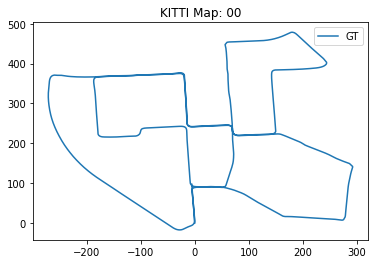

In [6]:
import matplotlib.pyplot as plt

plt.plot(path_x, path_y, label='GT')
plt.title('KITTI Map: ' + MAP)
plt.legend()
plt.show()

## Keypoints extraction

In [7]:
loam_eval_path = '../LOAM_KITTI_eval/' + MAP + '.txt' 

In [8]:
loam_odom_x = []
loam_odom_y = []
loam_odom = []
with open(loam_eval_path, newline='') as csvfile:
    odometry_reader = csv.reader(csvfile, delimiter=',')
    for row in odometry_reader:
        row = [float(i) for i in row]
        loam_odom.append(row)
        loam_odom_x.append(-row[1])
        loam_odom_y.append(row[0])

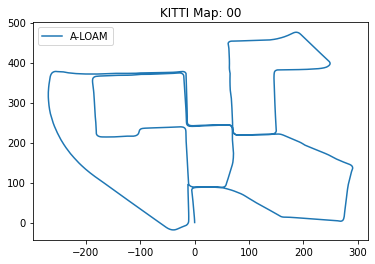

In [9]:
import matplotlib.pyplot as plt

plt.plot(loam_odom_x, loam_odom_y, label='A-LOAM')
plt.title('KITTI Map: ' + MAP)
plt.legend()
plt.show()

## Simple SLAM class

In [10]:
class UsipSLAM:
    def __init__(self, optimization_step=1):
        self.poses_id = []
        self.prev_keypoints = None
        self.prev_keypoints_ids = None
        self.graph = mrob.fgraph.FGraph()
        self.last_pos = np.eye(4)
        self.optimization_step = optimization_step
        
        # Class members to gather statistics
        self.corres_cnt = []
        self.opt_time = []
        self.chi2_errors = []
        self.observations_info = [] # (landmark_id, observation, pose_id)

    # delta_T -- transformation from LOAM between consequtive keypoints
    # keypoints -- keypoints associated with considered pcd
    def add_state(self, delta_T, keypoints):
        self.graph.print(True)
        T = self.last_pos @ delta_T
        if not self.poses_id:
            # Add anchor pose
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(np.eye(4)))
            self.graph.add_factor_1pose_3d(mrob.geometry.SE3(), p, 1e6 * np.eye(6))
            self.poses_id.append(p)
            
            # Remember last keypoints for association on the next step
            self.prev_keypoints = keypoints
            self.prev_keypoints_ids = np.zeros(keypoints.shape[0], dtype=int)
        
        # Add non-anchor pose
        else:
            # Add pose factor
            p = self.graph.add_node_pose_3d(mrob.geometry.SE3(T))
            self.graph.add_factor_2poses_3d(mrob.geometry.SE3(delta_T), p, self.poses_id[-1], np.eye(6))
            self.poses_id.append(p)
            
            corresp = find_correspondences(self.prev_keypoints, keypoints, delta_T)
            self.corres_cnt.append(len(corresp))
            
            keypoint_ids = np.zeros(keypoints.shape[0], dtype=int)
            # Add factors to corresponding pairs of landmarks
            for pair in corresp:
                # If we didn't add this keypoint to graph
                if self.prev_keypoints_ids[pair[0]] == 0:
                    l = self.graph.add_node_landmark_3d(np.zeros(3))                
                    self.graph.add_factor_1pose_1landmark_3d(keypoints[pair[1]], p, l, np.eye(3), initializeLandmark=True)
                    self.graph.add_factor_1pose_1landmark_3d(self.prev_keypoints[pair[0]], self.poses_id[-2], 
                                                             l, np.eye(3))
                    keypoint_ids[pair[1]] = l
                    self.observations_info.append((l, keypoints[pair[1]], p))
                    self.observations_info.append((l, self.prev_keypoints[pair[0]], self.poses_id[-2]))
                
                # If that keypoint is already in the graph
                else:
                    self.graph.add_factor_1pose_1landmark_3d(keypoints[pair[1]], p,
                                                             self.prev_keypoints_ids[pair[0]], np.eye(3))
                    keypoint_ids[pair[1]] = self.prev_keypoints_ids[pair[0]]
                    
                    self.observations_info.append((self.prev_keypoints_ids[pair[0]], keypoints[pair[1]], p))

            # Remember last keypoints for association on the next step
            self.prev_keypoints = keypoints
            self.prev_keypoints_ids = keypoint_ids
            
            # Optimize graph if we reached specified number of iterations
            if len(self.poses_id) % self.optimization_step == 0:
                print('Graph optimization')
                start_time = time.time()
                self.graph.solve(mrob.fgraph.LM)
                self.opt_time.append(time.time() - start_time)
            
            self.chi2_errors.append(self.graph.chi2())
            
            # Remember last pose
            self.last_pos = self.graph.get_estimated_state()[self.poses_id[-1]]
    
    def get_poses(self):
        state = self.graph.get_estimated_state()
        return [state[i][:3, 3] for i in self.poses_id]

## Evaluation

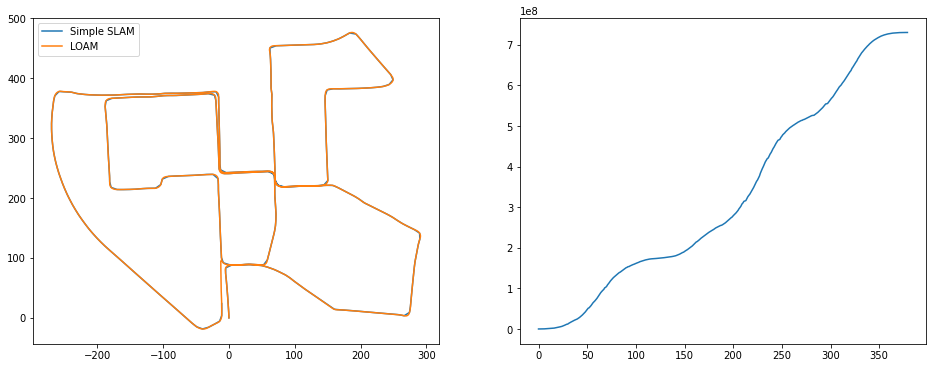

Graph optimization


In [11]:
calib_T = np.linalg.inv(np.array([4.276802385584e-04, -9.999672484946e-01, -8.084491683471e-03, -1.198459927713e-02, 
                    -7.210626507497e-03, 8.081198471645e-03, -9.999413164504e-01, -5.403984729748e-02, 
                    9.999738645903e-01, 4.859485810390e-04, -7.206933692422e-03, -2.921968648686e-01,
                   0, 0, 0, 1]).reshape(4, 4))

keypoint_files = os.listdir(KEYPOINTS_PATH)
keypoint_files.sort()
slam = UsipSLAM(optimization_step=len(keypoint_files) - 2)
# slam = UsipSLAM(optimization_step=300)

start_time = time.time()
times = []

prev_T = np.eye(4)
for i, filename in enumerate(keypoint_files[:-1]):
    idx = filename.split('.')[0]
    keypoints = transform_array(get_point_cloud(KEYPOINTS_PATH + idx + '.bin', is_keypoint=True), calib_T)
    
    T_t = quat_to_transform(loam_odom[int(idx)])
#     with mrob.ostream_redirect(stdout=True, stderr=True):
    slam.add_state(np.linalg.inv(prev_T) @ T_t, keypoints)
    times.append(time.time() - start_time)

    prev_T = T_t
    
    if i % 20 == 0:
        poses = slam.get_poses()
        clear_output(True)
        pos_x = []
        pos_y = []
        for i in range(len(poses)):
            pos_x.append(-poses[i][1])
            pos_y.append(poses[i][0])
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        ax1.plot(pos_x, pos_y, label='Simple SLAM')
        ax1.plot(loam_odom_x, loam_odom_y, label='LOAM')
        ax1.legend(['Simple SLAM', 'LOAM'])
        ax2.plot(slam.chi2_errors)
        plt.show()

In [12]:
start_time = time.time()
slam.graph.solve(mrob.fgraph.LM)
last_time = time.time() - start_time
slam.chi2_errors.append(slam.graph.chi2())
poses = slam.get_poses()
pos_x = []
pos_y = []
for i in range(len(poses)):
    pos_x.append(-poses[i][1])
    pos_y.append(poses[i][0])

In [13]:
slam.opt_time.append(last_time)

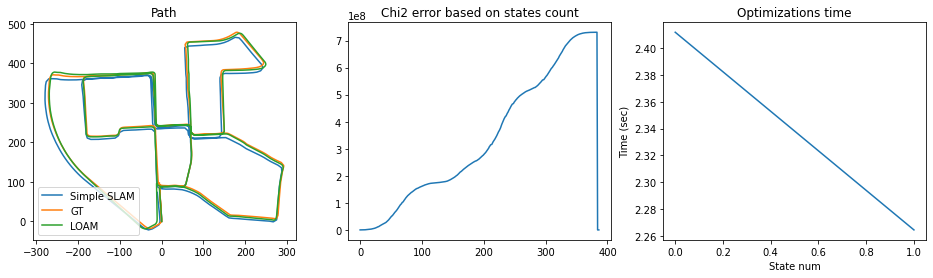

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))
ax1.plot(pos_x, pos_y)
ax1.plot(path_x, path_y)
ax1.plot(loam_odom_x, loam_odom_y)
ax1.set_title('Path')
ax1.legend(['Simple SLAM', 'GT', 'LOAM'])
ax2.plot(slam.chi2_errors)
ax2.set_title('Chi2 error based on states count')
ax3.plot(slam.opt_time)
ax3.set_xlabel('State num')
ax3.set_ylabel('Time (sec)')
ax3.set_title('Optimizations time')
plt.show()

## Statistics

### Landmark correspondences

In [15]:
import statistics

print('Min num of corresp: {0}'.format(min(slam.corres_cnt)))
print('Max num of corresp: {0}'.format(max(slam.corres_cnt)))
print('Median num of corresp: {0}'
      .format(statistics.median(slam.corres_cnt)))

Min num of corresp: 4
Max num of corresp: 44
Median num of corresp: 29.0


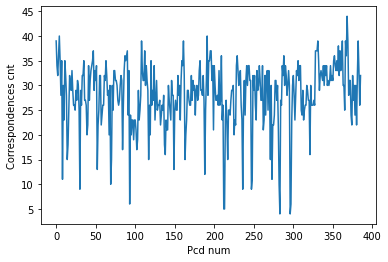

In [16]:
plt.plot(slam.corres_cnt)
plt.xlabel('Pcd num')
plt.ylabel('Correspondences cnt')
plt.show()

### Time performance

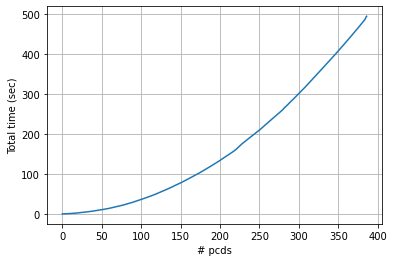

In [17]:
plt.plot(times)
plt.xlabel('# pcds')
plt.ylabel('Total time (sec)')
plt.grid(True)
plt.show()

### Observation covariances

In [18]:
def mean(obs):
    return np.mean(np.vstack(obs), axis=0)

def cov(obs):
    return np.cov(np.vstack(obs).T)

# It is not optimal, sure, but it works
def observation_statistics(observation_info, source='slam'):
    landmark_ids = []
    for landmark_id, _, _ in observation_info:
        landmark_ids.append(landmark_id)
    
    obs_sort_by_landmark_id = [observation_info[i] for i in np.argsort(landmark_ids)]
    
    prev_landmark_id = 0
    landmark_cov = []
    obs_list = []

    for landmark_id, obs, pose_id in obs_sort_by_landmark_id:
        if prev_landmark_id == landmark_id:
            if source == 'loam':
                filename = keypoint_files[slam.poses_id.index(pose_id)]
                filename_idx = filename.split('.')[0]
                landmark_pose = transform_array(obs.reshape(1, 3), quat_to_transform(loam_odom[int(filename_idx)]))
            else:
                landmark_pose = transform_array(obs.reshape(1, 3), slam.graph.get_estimated_state()[pose_id])
            obs_list.append(landmark_pose)
        else:
            if len(obs_list) > 1:
                landmark_cov.append((landmark_id, cov(obs_list), len(obs_list), mean(obs_list)))
            
            prev_landmark_id = landmark_id
            obs_list = []
    
    return landmark_cov

In [19]:
landmark_cov = observation_statistics(slam.observations_info)

In [20]:
import sys

for landmark_id, cov_matrix, landmark_rep, mean in landmark_cov:
    print('Landmark id: {0}, rep: {1}\n'.format(landmark_id, landmark_rep))
    print('Covariance from SLAM algo\n', cov_matrix)
    landmark_cov_loam
#     print(mean)
    print('\n')

Landmark id: 4, rep: 3

Covariance from SLAM algo
 [[0.00153798 0.00074607 0.00483348]
 [0.00074607 0.00165658 0.00651824]
 [0.00483348 0.00651824 0.02864432]]


NameError: name 'landmark_cov_loam' is not defined

In [58]:
def vizualize_keypoints(desired_landmark_id):
    pcds_list = []
    for landmark_id, obs, pose_id in slam.observations_info:
        if landmark_id == desired_landmark_id:
            filename = keypoint_files[slam.poses_id.index(pose_id)]
            filename_idx = filename.split('.')[0]
            pcd = get_point_cloud(KITTI_PCDS_PATH + filename_idx + '.bin', is_keypoint=False)
            T = slam.graph.get_estimated_state()[pose_id]
            transformed_pcd = get_pcd_from_numpy(pcd).transform(T)
            pcds_list.append(transformed_pcd)
            keypoint_sphere = o3d.geometry.TriangleMesh.create_sphere(radius=0.5).translate(obs).transform(T)
            keypoint_sphere.paint_uniform_color([1, 0, 0])
            pcds_list.append(keypoint_sphere)
#             o3d.visualization.draw_geometries([transformed_pcd, keypoint_sphere])
    
    o3d.visualization.draw_geometries(pcds_list)

vizualize_keypoints(3)

## Visualize map

### SLAM map

In [28]:
pcds_list = []
for i, filename in enumerate(keypoint_files[:-1]):
    filename_idx = filename.split('.')[0]
    pcd = get_point_cloud(KITTI_PCDS_PATH + filename_idx + '.bin', is_keypoint=False)
    T = slam.graph.get_estimated_state()[slam.poses_id[i]]
    transformed_pcd = get_pcd_from_numpy(pcd).transform(T)
    pcds_list.append(transformed_pcd)

In [29]:
main_pcd = pcds_list[0]
for pcd in pcds_list[1:]:
    main_pcd += pcd

In [30]:
downpcd = main_pcd.voxel_down_sample(voxel_size=1)
o3d.io.write_point_cloud("big_map_00.pcd", downpcd)

True

### LOAM map

In [30]:
pcds_list = []
T_s = []
for i, filename in enumerate(keypoint_files[:-1]):
    filename_idx = filename.split('.')[0]
    pcd = get_point_cloud(KITTI_PCDS_PATH + filename_idx + '.bin', is_keypoint=False)
#     T = np.vstack((odometry[int(filename_idx)], np.array([0, 0, 0, 1])))
    T = quat_to_transform(loam_odom[int(idx)])
    T_s.append(T[:3, 3])
    transformed_pcd = get_pcd_from_numpy(pcd).transform(T)
    pcds_list.append(transformed_pcd)

In [34]:
downpcd = main_pcd.voxel_down_sample(voxel_size=1)
o3d.io.write_point_cloud("loam_map_00.pcd", downpcd)

True

In [39]:
x = []
y = []
z = []
for T in T_s:
    x.append(T[0])
    y.append(T[1])
    z.append(T[2])

In [40]:
x1 = []
y1 = []
z1 = []
for T in T_s:
    x1.append(T[0])
    y1.append(T[1])
    z1.append(T[2])

In [41]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D

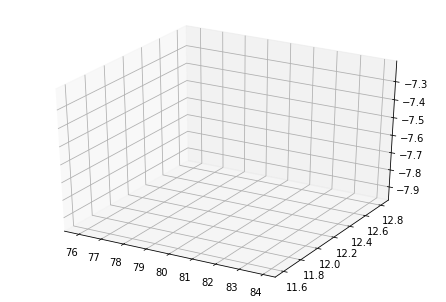

In [43]:
fig = pyplot.figure()
ax = Axes3D(fig)
# ax.plot(x1, y1, z1)
ax.plot(x, y, z)